In [2]:
require(rgdal)
library(ggplot2)
library(gstat)
library(sp)
library(maptools)
library(raster)

In [3]:
setwd("D:/Interpolation_AQI/Interpolation_AQI")

In [4]:
data2 <- read.csv('station_aqi.csv', header = T)
data <- na.omit(data2)
data_test <- data
data_test$x <- data$longitude
data_test$y <- data$latitude
coordinates(data_test) = ~x + y

In [5]:
x.range <- as.numeric(c(66.70, 98.28))   # min/max longitude of the interpolation area

y.range <- as.numeric(c(6.30, 37.35))  # min/max latitude of the interpolation area

grd <- expand.grid(x = seq(from = x.range[1], to = x.range[2], by = 0.1), y = seq(from = y.range[1], 
                                                                                  to = y.range[2], by = 0.1))  # expand points to grid
coordinates(grd) <- ~x + y
gridded(grd) <- TRUE

ind_contour <- readOGR("D:/Interpolation_AQI/Interpolation_AQI/IndiaShapeFile/IndiaFull.shp")
#est_contour <- fortify(est_contour, region = "name")

OGR data source with driver: ESRI Shapefile 
Source: "D:\Interpolation_AQI\Interpolation_AQI\IndiaShapeFile\IndiaFull.shp", layer: "IndiaFull"
with 46 features
It has 14 fields
Integer64 fields read as strings:  ID_0 ID_1 ID_2 ID_3 CCN_3 id 


In [6]:
idw <- idw(formula = aqi ~ 1, data_test, 
           newdata = grd, idp = 2)  # apply idw model for the data


idw.output = as.data.frame(idw)  # output is defined as a data table
idw.r <- rasterFromXYZ(idw.output[, c("x", "y", "var1.pred")])
idw.crp <- crop(idw.r, ind_contour)
idw.msk <- mask(idw.crp, ind_contour)
idw.msk.dfr <- as.data.frame(rasterToPoints(idw.msk))
names(idw.output)[1:3] <- c("long", "lat", "AQI_level")  # give names to the modelled variables

[inverse distance weighted interpolation]


Regions defined for each Polygons


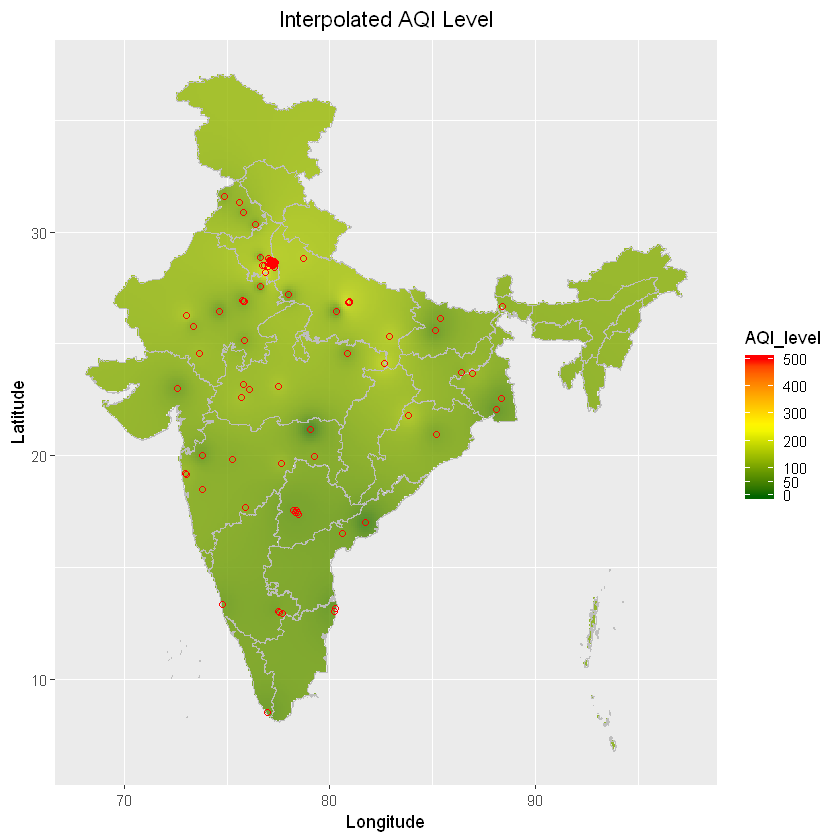

In [7]:
ggplot() + 
  geom_tile(data = idw.msk.dfr, alpha = 0.8, aes(x = x, y = y, fill = round(var1.pred, 0))) + 
  scale_fill_gradientn(colours = c(low = "darkgreen", mid = "yellow",high = "red"), limits = c(0,500), breaks = c(0,50,100,200,300,400,500)) +
  geom_path(data = ind_contour, aes(long, lat, group = group), colour = "grey") + 
  geom_point(data = data, aes(x = longitude, y = latitude), shape = 21, colour = "red") + 
  labs(fill = "AQI_level", x = "Longitude", y = "Latitude",title = "Interpolated AQI Level") +
  theme(plot.title = element_text(hjust = 0.5))